
## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test), len(fmnist_dataset_train)

(10000, 60000)

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
# def set_random_seed(seed):
#     torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)

# set_random_seed(101)

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [1]:
# torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Your experiments come here:

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
# # Your experiments, training and validation loops here

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

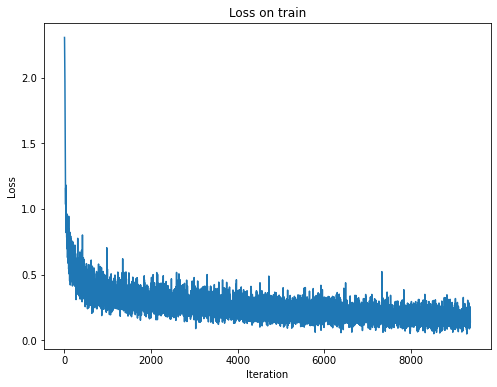

100%|██████████| 20/20 [04:21<00:00, 13.05s/it]

Current loss: 0.138893
CPU times: user 3min 16s, sys: 12.3 s, total: 3min 29s
Wall time: 4min 21s


In [ ]:
%%time
n_epochs = 20
train_loss = []

model.train(True)
for epoch in tqdm(range(n_epochs)):
  for x_batch, y_batch in train_loader:
    opt.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    predictions = model.forward(x_batch)
    loss = loss_func(predictions, y_batch)
    train_loss.append(loss)
    loss.backward()
    opt.step()
      

  clear_output(wait=True) 
  plt.figure(figsize=(8, 6))

  plt.title('Loss on train')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.plot(train_loss)
  plt.show()

  print('Current loss: %f' % loss)

In [ ]:
loss_list = []
accuracy_list = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(x_batch)
        y_pred = predictions.max(1)[1]
        loss = loss_func(predictions, y_batch)
        loss_list.append(loss.item())
        accuracy_list.append(((y_batch.cpu() == y_pred.cpu()).numpy()).mean())

In [ ]:
print("Mean Accuracy on test: {}".format(np.mean(accuracy_list)))

Mean Accuracy on test: 0.89267578125


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
        LogSoftmax-9                   [-1, 10]               0
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
-------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
# Your experiments, come here

 Let's decrease the size of train dataset.

In [ ]:
fmnist_dataset_train_subset, _ = torch.utils.data.random_split(fmnist_dataset_train, [5000, 55000])

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train_subset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
def plot_loss_and_acc(train_loss, test_loss, train_accuracy, test_accuracy):
  clear_output(wait=True)
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].set_title('Loss')
  axes[0].plot(train_loss, label='Train')
  axes[0].plot(test_loss, label='Test')
  axes[0].legend()
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  
  axes[1].set_title('Accuracy')
  axes[1].plot(train_accuracy, label='Train')
  axes[1].plot(test_accuracy, label='Test')
  axes[1].legend()
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  plt.show()

In [ ]:
def train_model(model, train_loader, test_loader, loss_func, opt, n_epochs):
  train_loss = []
  test_loss = []
  train_accuracy = [] 
  test_accuracy = []
  # min_test_loss = np.Inf
  model.train()
  for epoch in tqdm(range(n_epochs)):
      run_loss = 0
      val_loss = 0

      epoch_train_accuracy = []
      epoch_test_accuracy = []

      for x_batch, y_batch in train_loader:
          opt.zero_grad()
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          predictions = model(x_batch)
          loss = loss_func(predictions, y_batch)
          loss.backward()
          opt.step()

          run_loss += loss.item() * x_batch.size(0) 
          y_pred = predictions.max(1)[1].data
          epoch_train_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
          # accuracy = (predicts == labels).to(torch.float).mean() # another way
          # train_accuracies += [accuracy.item()] # another way
      # model.eval()
      # with torch.no_grad():
      for x_batch, y_batch in test_loader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          predictions = model(x_batch)
          loss = loss_func(predictions, y_batch)

          val_loss += loss.item() * x_batch.size(0)
          y_pred = predictions.max(1)[1].data
          epoch_test_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

      run_loss = run_loss / len(train_loader.sampler)
      val_loss = val_loss / len(test_loader.sampler)
      train_loss.append(run_loss)
      test_loss.append(val_loss)

      test_accuracy.append(np.mean(epoch_test_accuracy))
      train_accuracy.append(np.mean(epoch_train_accuracy))

      # if test_loss <= min_test_loss:
      #   torch.save(model.state_dict(), 'model.pt')
      #   min_test_loss = test_loss
      
      plot_loss_and_acc(train_loss, test_loss, train_accuracy, test_accuracy)
  return train_loss, test_loss, train_accuracy, test_accuracy

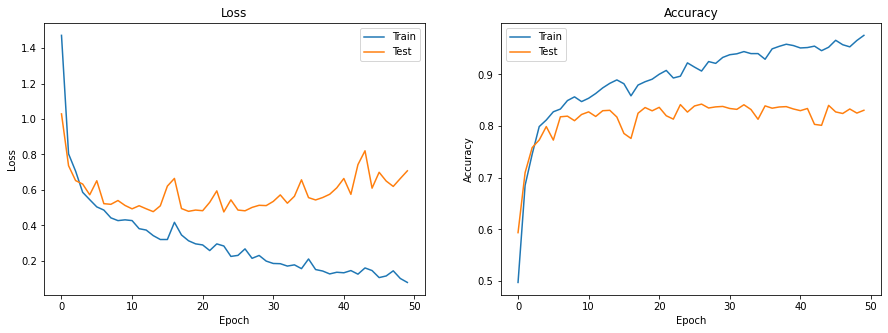

100%|██████████| 50/50 [02:25<00:00,  2.91s/it]

CPU times: user 58.3 s, sys: 8.98 s, total: 1min 7s
Wall time: 2min 25s


In [ ]:
%%time
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

n_epochs = 50
overfit_history = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

In [ ]:
print("Last 5 epochs avg train loss: {}".format(np.mean(overfit_history[0][-5:])))
print("Last 5 epochs avg test loss: {}".format(np.mean(overfit_history[1][-5:])))
print("Loss difference: {}".format(np.mean(np.mean(overfit_history[1][-5:]) - overfit_history[0][-5:])))

Last 5 epochs avg train loss: 0.10825357252195478
Last 5 epochs avg test loss: 0.668133146352768
Loss difference: 0.5598795738308132


As can be seen, the model is overfitted.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
# Your experiments, come here

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
       BatchNorm1d-5                  [-1, 256]             512
            Linear-6                  [-1, 128]          32,896
           Dropout-7                  [-1, 128]               0
              ReLU-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 64]           8,256
          Dropout-11                   [-1, 64]               0
             ReLU-12                   [-1, 64]               0
      BatchNorm1d-13                   [-1, 64]             128
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


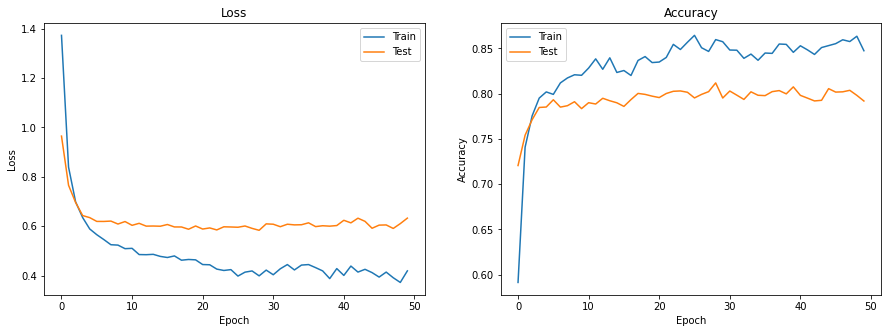

100%|██████████| 50/50 [02:28<00:00,  2.97s/it]

CPU times: user 1min 5s, sys: 9.17 s, total: 1min 14s
Wall time: 2min 28s


In [ ]:
%%time
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 50

fixed_history = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

In [ ]:
print("Last 5 epochs avg train loss: {}".format(np.mean(fixed_history[0][-5:])))
print("Last 5 epochs avg test loss: {}".format(np.mean(fixed_history[1][-5:])))
print("Loss difference: {}".format(np.mean(np.mean(fixed_history[1][-5:]) - fixed_history[0][-5:])))

Last 5 epochs avg train loss: 0.39785686054468156
Last 5 epochs avg test loss: 0.6084606928396225
Loss difference: 0.21060383229494092


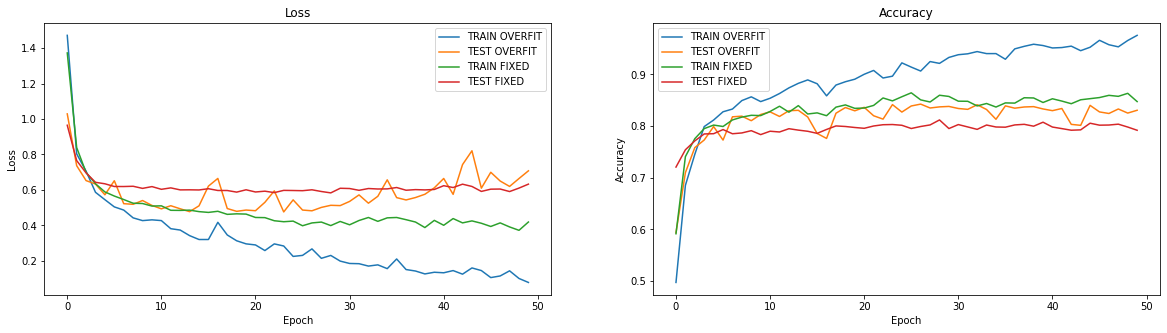

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].set_title('Loss')
axes[0].plot(overfit_history[0], label='TRAIN OVERFIT')
axes[0].plot(overfit_history[1], label='TEST OVERFIT')
axes[0].plot(fixed_history[0], label='TRAIN FIXED')
axes[0].plot(fixed_history[1], label='TEST FIXED')
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].set_title('Accuracy')
axes[1].plot(overfit_history[2], label='TRAIN OVERFIT')
axes[1].plot(overfit_history[3], label='TEST OVERFIT')
axes[1].plot(fixed_history[2], label='TRAIN FIXED')
axes[1].plot(fixed_history[3], label='TEST FIXED')
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

The model was overfitted on a dataset of size 5000 and the number of parameters 242762.
Overfitting is minimal if you build layers in the following order: linear, dropout, relu, batchnorm. The optimal droput value is 0.3. You can use other regularization methods (I have no idea which ones) and gridsearch/randomsearch when selecting hyperparameters.